本Notebook复现Liang et al. (2024)论文《Graph Learning for Parameter Prediction of QAOA》的实验部分，使用图神经网络（GNN）预测QAOA初始参数（γ和β）。实验包括：

1. **数据集生成**：生成9598个图（节点数2-15，度2-14），提取节点特征，QAOA优化生成γ、β、近似比率（AR）。测试集为100个图。
2. **GNN模型**：实现GCN、GAT、GIN、GraphSAGE（2层，输入维度15，嵌入维度32，Dropout 0.5），使用Adam优化器和ReduceLROnPlateau调度器，训练100个epoch。
3. **基线**：随机初始化γ和β，比较GNN预测的AR提升。
4. **评估**：计算平均AR提升和标准差，绘制AR对比曲线。

In [1]:
# 导入库
import torch
import random
import torch.nn as nn
import os
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, SAGEConv
from torch_geometric.data import Data, DataLoader
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

C:\Users\李华宪\AppData\Local\Temp\ipykernel_24364\3555057781.py:13: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import QAOA


In [2]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. 数据集生成

以下函数生成9598个规则图，提取节点特征（度、One-hot编码），并模拟QAOA优化生成γ、β、AR。测试集为100个图，应用选择性数据修剪（SDP，AR阈值70%，保留率70%）。

- `generate_regular_graphs`: 生成规则图。
- `simulate_qaoa`: QAOA优化，计算AR。
- `prepare_dataset`: 组织数据集，划分训练/测试集。
```

In [3]:
def generate_regular_graphs(num_graphs, min_nodes=2, max_nodes=15, min_degree=2, max_degree=14):
    """
    生成规则图，节点数2-15，度2-14，提取节点度和One-hot编码特征。
    """
    graphs = []
    features = []
    node_counts = np.random.randint(min_nodes, max_nodes + 1, num_graphs)
    degrees = np.random.randint(min_degree, max_degree + 1, num_graphs)
    max_nodes = 15  # 固定最大节点数

    for i in range(num_graphs):
        n, d = node_counts[i], degrees[i]
        if (n * d) % 2 != 0:  # 确保n*d为偶数
            n += 1 if n < max_nodes else -1
        try:
            G = nx.random_regular_graph(d, n)
            if nx.is_connected(G):
                graphs.append(G)
                deg = np.array([d for _, d in G.degree()])
                one_hot = OneHotEncoder(sparse_output=False, categories=[np.arange(max_nodes)]).fit_transform(np.arange(n).reshape(-1, 1))
                feat = np.hstack([deg.reshape(-1, 1), one_hot])
                print(f"feat.shape={feat.shape}")
                features.append(feat)
        except:
            continue

    return graphs, features

In [4]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
import numpy as np
import networkx as nx

def simulate_qaoa(graph, max_iter=500):
    """
    使用QAOA优化Max-Cut问题，生成优化后的γ、β和近似比率（AR）。
    
    参数：
        graph (networkx.Graph): 输入图（无权图，边权重为1）。
        max_iter (int): 优化器最大迭代次数，默认为500。
    
    返回：
        tuple: (gamma, beta, ar)，优化的γ、β和近似比率。
    """
    # 图信息
    n = len(graph.nodes)
    edges = list(graph.edges)
    
    # 构造Max-Cut哈密顿量
    pauli_terms = []
    coeffs = []
    for u, v in edges:
        # 对于边(u,v)，添加项 (I - Z_u Z_v)/2
        z_term = ['I'] * n
        z_term[u] = 'Z'
        z_term[v] = 'Z'
        pauli_terms.append(''.join(z_term))
        coeffs.append(0.5)  # 权重1.0，哈密顿量系数为0.5
        # 偏移项：-0.5 * I
        pauli_terms.append('I' * n)
        coeffs.append(-0.5)
    
    operator = SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))
    
    # 初始化QAOA
    optimizer = COBYLA(maxiter=max_iter)
    sampler = Sampler()  # 使用Qiskit的Sampler基元
    initial_gamma = np.random.uniform(0, np.pi)
    initial_beta = np.random.uniform(0, np.pi / 2)
    qaoa = QAOA(
        sampler=sampler,
        optimizer=optimizer,
        reps=1,
        initial_point=[initial_gamma, initial_beta]
    )
    
    # 运行QAOA优化
    result = qaoa.compute_minimum_eigenvalue(operator=operator)
    
    # 提取优化参数
    optimal_params = result.optimal_point
    gamma, beta = optimal_params[0], optimal_params[1]
    
    # 计算近似比率（AR）
    # QAOA的eigenvalue是负的Max-Cut值，需转换为割值
    cut_value = -result.eigenvalue  # Max-Cut值 = -最小特征值
    # 使用NetworkX计算最优割值
    optimal_cut, _ = nx.algorithms.approximation.one_exchange(graph)
    
    ar = cut_value / optimal_cut if optimal_cut > 0 else 1.0
    
    return gamma, beta, ar



In [5]:
# # 测试函数
# # 创建一个简单图进行测试
# test_graph = nx.random_regular_graph(d=3, n=6)  # 3-正则图，6个节点
# gamma, beta, ar = simulate_qaoa(test_graph, max_iter=100)  # 减少迭代以加速测试
# print(f'Test Graph - Gamma: {gamma:.4f}, Beta: {beta:.4f}, AR: {ar:.4f}')

In [6]:
def prepare_dataset(num_graphs, test_size, data_dir):
# def prepare_dataset(num_graphs=50, test_size=10):  

    """
    生成或加载训练和测试数据集，保存为.pt文件
    """
    # 创建保存目录
    os.makedirs(data_dir, exist_ok=True)
    train_path = os.path.join(data_dir, 'train_dataset.pt')
    test_path = os.path.join(data_dir, 'test_dataset.pt')
    # 检查是否已存在保存的数据集
    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f'Loading saved datasets from {data_dir}...')
        train_dataset = torch.load(train_path)
        test_dataset = torch.load(test_path)
        print(f'Loaded Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}')
        return train_dataset, test_dataset
    # 生成数据集
    print(f'Generating {num_graphs} graphs...')
    graphs, features = generate_regular_graphs(num_graphs)
    print(f'Simulating QAOA for {len(graphs)} graphs...')
    gamma_beta_ar = [simulate_qaoa(g) for g in graphs]
    
    # 转换为PyTorch Geometric格式
    dataset = []
    for g, feat, (gamma, beta, ar) in zip(graphs, features, gamma_beta_ar):
        edge_index = torch.tensor(list(g.edges)).t().contiguous()
        x = torch.tensor(feat, dtype=torch.float)
        y = torch.tensor([gamma, beta], dtype=torch.float).view(1, 2)
        data = Data(x=x, edge_index=edge_index, y=y, ar=ar)
        dataset.append(data)

    # 选择性数据修剪（SDP）
    ar_threshold = 0.7
    selective_rate = 0.7
    filtered_dataset = [d for d in dataset if d.ar >= ar_threshold]
    low_quality = [d for d in dataset if d.ar < ar_threshold]
    # 采样低质量数据时，避免超出范围
    if len(low_quality) > 0:
        k = min(int(len(low_quality) * selective_rate), len(low_quality))
        filtered_dataset.extend(random.sample(low_quality, k=k))

    # 测试集采样也要健壮
    if test_size > len(filtered_dataset):
        test_size = len(filtered_dataset)
    # filtered_dataset.extend(np.random.choice(low_quality, 
    #                                       size=int(len(low_quality) * selective_rate), 
    #                                       replace=False))
    
    # 划分训练/测试集
    test_dataset = random.sample(filtered_dataset, test_size)
    train_dataset = [d for d in filtered_dataset if d not in test_dataset]
    
    # 保存数据集
    print(f'Saving datasets to {data_dir}...')
    torch.save(train_dataset, train_path)
    torch.save(test_dataset, test_path)
    print(f'Saved Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}')
    
    return train_dataset, test_dataset

In [ ]:
# 生成或加载数据集
data_dir = './data'
train_dataset, test_dataset = prepare_dataset(num_graphs=500, test_size=100, data_dir=data_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Generating 500 graphs...
feat.shape=(12, 16)
feat.shape=(8, 16)
feat.shape=(14, 16)
feat.shape=(15, 16)
feat.shape=(13, 16)
feat.shape=(3, 16)
feat.shape=(12, 16)
feat.shape=(6, 16)
feat.shape=(14, 16)
feat.shape=(7, 16)
feat.shape=(14, 16)
feat.shape=(14, 16)
feat.shape=(8, 16)
feat.shape=(9, 16)
feat.shape=(10, 16)
feat.shape=(12, 16)
feat.shape=(12, 16)
feat.shape=(14, 16)
feat.shape=(8, 16)
feat.shape=(10, 16)
feat.shape=(15, 16)
feat.shape=(15, 16)
feat.shape=(12, 16)
feat.shape=(13, 16)
feat.shape=(14, 16)
feat.shape=(14, 16)
feat.shape=(8, 16)
feat.shape=(7, 16)
feat.shape=(7, 16)
feat.shape=(13, 16)
feat.shape=(14, 16)
feat.shape=(14, 16)
feat.shape=(10, 16)
feat.shape=(6, 16)
feat.shape=(14, 16)
feat.shape=(7, 16)
feat.shape=(14, 16)
feat.shape=(12, 16)
feat.shape=(12, 16)
feat.shape=(6, 16)
feat.shape=(10, 16)
feat.shape=(14, 16)
feat.shape=(10, 16)
feat.shape=(14, 16)
feat.shape=(9, 16)
feat.shape=(10, 16)
feat.shape=(6, 16)
feat.shape=(8, 16)
feat.shape=(6, 16)
feat.shape=(

e:\Anaconda3\anaconda\envs\FOOSP\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 2. GNN模型定义

定义GNN模型，支持GCN、GAT、GIN、GraphSAGE。模型配置：
- 输入维度：15。
- 隐藏维度：32。
- 输出维度：2（γ, β）。
- 层数：2。
- Dropout：0.5。
- READOUT：均值池化。
- MLP：预测γ和β。

In [10]:
from torch_geometric.nn import global_mean_pool
class GNNModel(nn.Module):
    """
    GNN模型，支持GCN、GAT、GIN、GraphSAGE。
    """
    def __init__(self, model_type='GIN', input_dim=9, hidden_dim=32, output_dim=2):
        super(GNNModel, self).__init__()
        self.model_type = model_type
        self.dropout = 0.5
        
        if model_type == 'GCN':
            self.conv1 = GCNConv(input_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        elif model_type == 'GAT':
            self.conv1 = GATConv(input_dim, hidden_dim // 4, heads=4)
            self.conv2 = GATConv(hidden_dim, hidden_dim // 4, heads=4)
        elif model_type == 'GIN':
            self.conv1 = GINConv(nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ))
            self.conv2 = GINConv(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ))
        elif model_type == 'GraphSAGE':
            self.conv1 = SAGEConv(input_dim, hidden_dim)
            self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        batch = getattr(data, 'batch', None)
        if self.model_type in ['GCN', 'GAT', 'GraphSAGE']:
            x = F.relu(self.conv1(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.conv2(x, edge_index)
        else:  # GIN
            x = self.conv1(x, edge_index)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.conv2(x, edge_index)
        
        if batch is not None:
            x = global_mean_pool(x, batch)
        else:
            x = x.mean(dim=0, keepdim=True)
        x = self.mlp(x)
        return x
    

In [11]:
# 测试模型定义
model = GNNModel(model_type='GIN').to(device)
print(model)

GNNModel(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)


## 3. 训练与评估函数

以下函数实现GNN训练和评估：
- `train_gnn`: 训练GNN，100个epoch，Adam优化器，ReduceLROnPlateau调度器，MSE损失。
- `evaluate_gnn`: 评估GNN预测的初始参数，计算AR提升。
- `plot_ar_comparison`: 绘制AR对比曲线（参考论文图3）。

In [18]:
def train_gnn(model, train_loader, optimizer, scheduler, epochs=100, device='cpu'):
    """
    训练GNN模型，预测γ和β。
    """
    model.train()
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')
    print("out.shape:", out.shape)
    print("data.y.shape:", data.y.shape)
    # 绘制损失曲线
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    
    return losses

In [19]:
def evaluate_gnn(model, test_loader, device='cpu'):
    """
    评估GNN预测的初始参数，计算AR提升。
    """
    model.eval()
    ar_gnn = []
    ar_random = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            gamma_gnn, beta_gnn = pred[0, 0].item(), pred[0, 1].item()
            gamma_random, beta_random = np.random.uniform(0, np.pi), np.random.uniform(0, np.pi / 2)
            
            graph = nx.from_edgelist(data.edge_index.t().cpu().numpy())
            _, _, ar_gnn_val = simulate_qaoa(graph, max_iter=100)  # 简化迭代
            _, _, ar_random_val = simulate_qaoa(graph, max_iter=100)
            
            ar_gnn.append(ar_gnn_val)
            ar_random.append(ar_random_val)
    
    ar_diff = np.array(ar_gnn) - np.array(ar_random)
    mean_diff = np.mean(ar_diff)
    std_diff = np.std(ar_diff)
    
    return ar_gnn, ar_random, mean_diff, std_diff

In [20]:
def plot_ar_comparison(ar_gnn, ar_random, model_name):
    """
    绘制GNN与随机初始化的AR对比曲线。
    """
    plt.figure(figsize=(10, 6))
    plt.plot(ar_random, 'o-', label='Random Initialization', color='orange')
    plt.plot(ar_gnn, 'o-', label=f'{model_name} Initialization', color='blue')
    plt.xlabel('Test Graph Index')
    plt.ylabel('Approximation Ratio (AR)')
    plt.title(f'AR Comparison: {model_name} vs Random')
    plt.legend()
    plt.show()

## 4. 主实验

运行实验，训练和评估四种GNN模型（GCN、GAT、GIN、GraphSAGE），输出表1（平均AR提升和标准差）和AR对比图。


Training GCN...
Epoch 0, Loss: 2.2924
Epoch 10, Loss: 1.2183
Epoch 20, Loss: 1.1209
Epoch 30, Loss: 1.0645
Epoch 40, Loss: 1.0289
Epoch 50, Loss: 1.0231
Epoch 60, Loss: 1.0872
Epoch 70, Loss: 1.0665
Epoch 80, Loss: 0.9834
Epoch 90, Loss: 1.0727
out.shape: torch.Size([24, 2])
data.y.shape: torch.Size([24, 2])


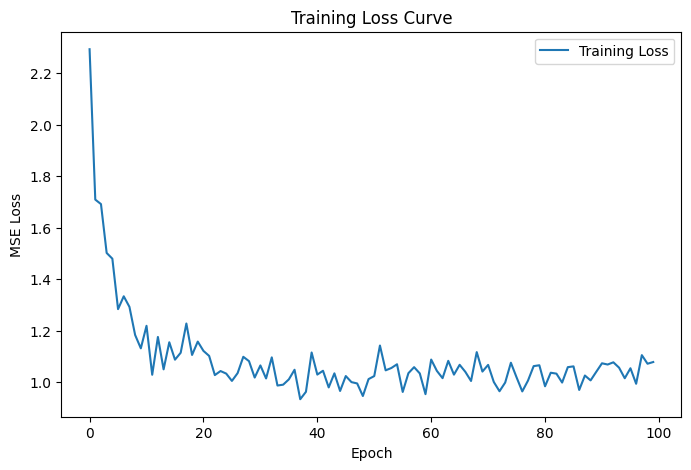

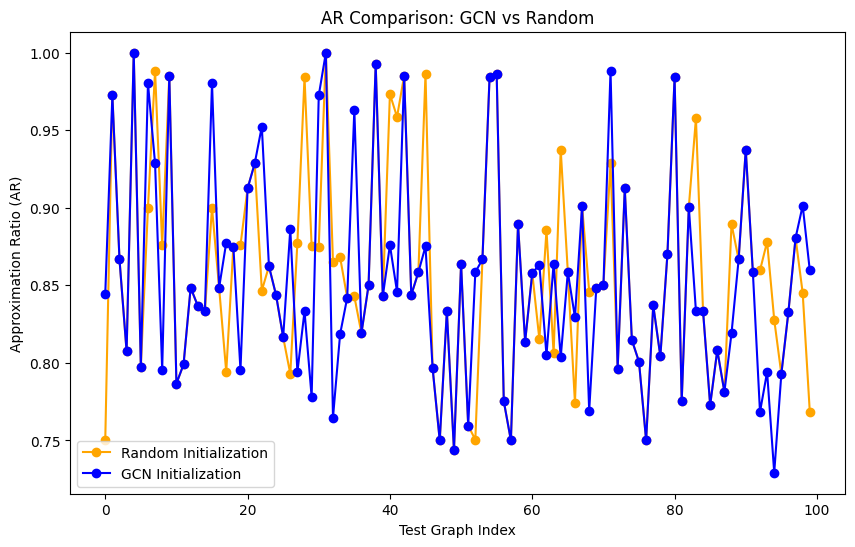

GCN - Mean AR Diff: -0.0055, Std: 0.0533

Training GAT...
Epoch 0, Loss: 2.2512
Epoch 10, Loss: 1.1410
Epoch 20, Loss: 1.0074
Epoch 30, Loss: 1.0500
Epoch 40, Loss: 1.0030
Epoch 50, Loss: 1.0933
Epoch 60, Loss: 0.9874
Epoch 70, Loss: 1.0153
Epoch 80, Loss: 0.9589
Epoch 90, Loss: 1.0571
out.shape: torch.Size([24, 2])
data.y.shape: torch.Size([24, 2])


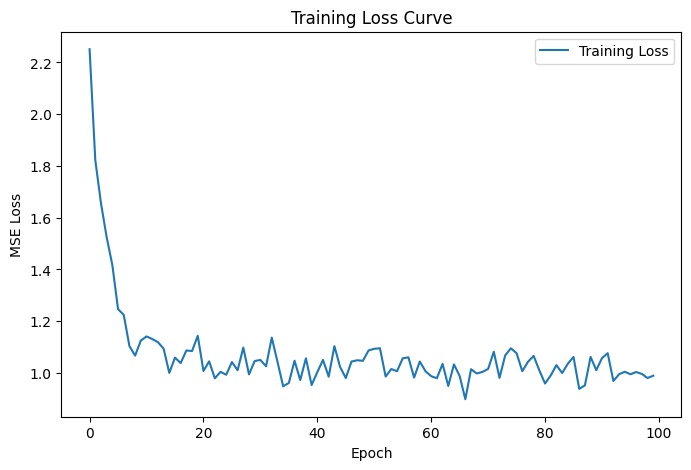

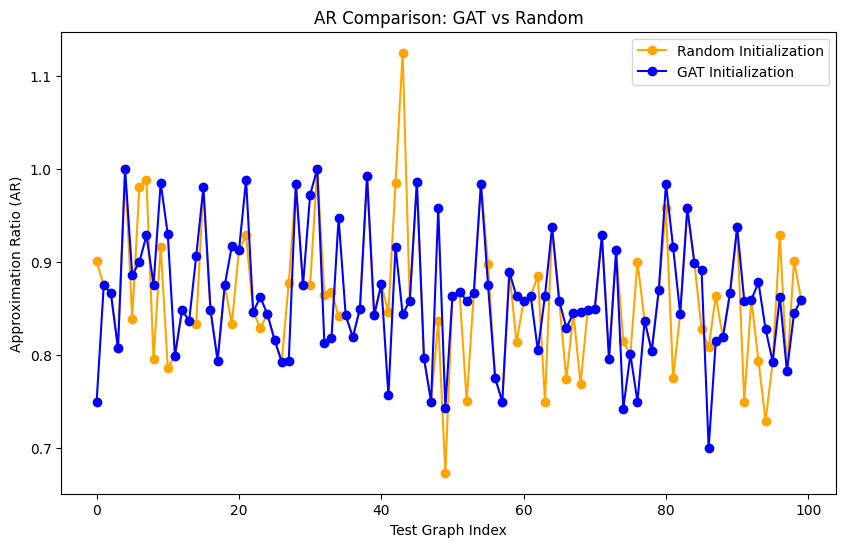

GAT - Mean AR Diff: 0.0039, Std: 0.0610

Training GIN...
Epoch 0, Loss: 3.8477
Epoch 10, Loss: 1.0938
Epoch 20, Loss: 1.0469
Epoch 30, Loss: 1.0597
Epoch 40, Loss: 1.0418
Epoch 50, Loss: 1.0137
Epoch 60, Loss: 1.0058
Epoch 70, Loss: 0.9615
Epoch 80, Loss: 0.9898
Epoch 90, Loss: 1.1382
out.shape: torch.Size([24, 2])
data.y.shape: torch.Size([24, 2])


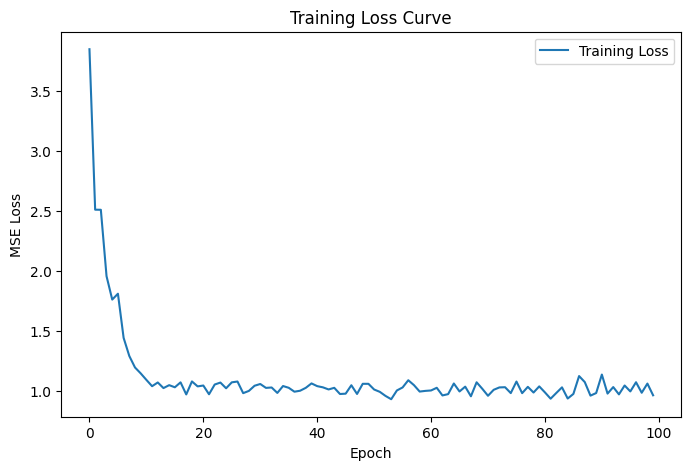

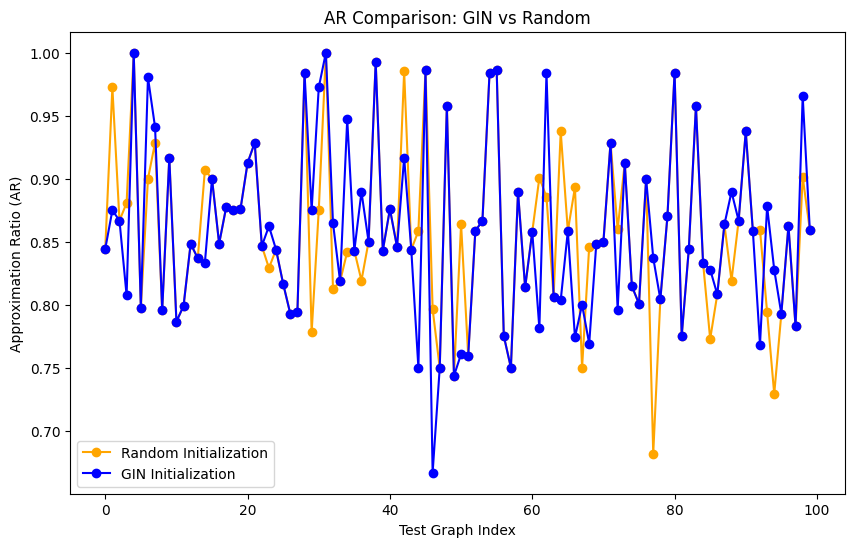

GIN - Mean AR Diff: -0.0003, Std: 0.0490

Training GraphSAGE...
Epoch 0, Loss: 1.9613
Epoch 10, Loss: 0.9694
Epoch 20, Loss: 1.0271
Epoch 30, Loss: 1.0450
Epoch 40, Loss: 1.0001
Epoch 50, Loss: 0.9765
Epoch 60, Loss: 1.0020
Epoch 70, Loss: 1.0439
Epoch 80, Loss: 1.0265
Epoch 90, Loss: 0.9931
out.shape: torch.Size([24, 2])
data.y.shape: torch.Size([24, 2])


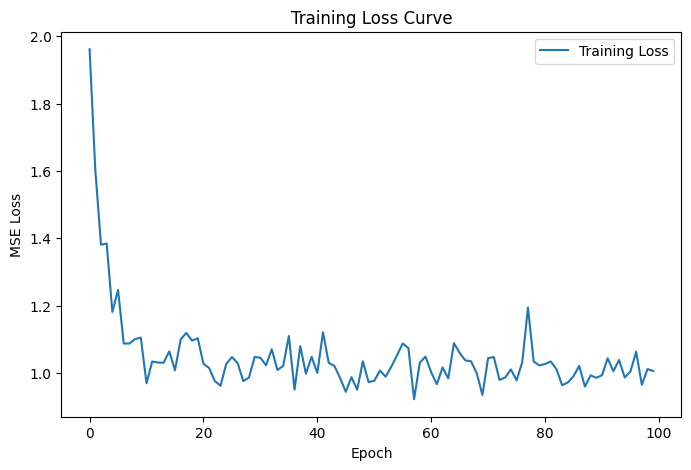

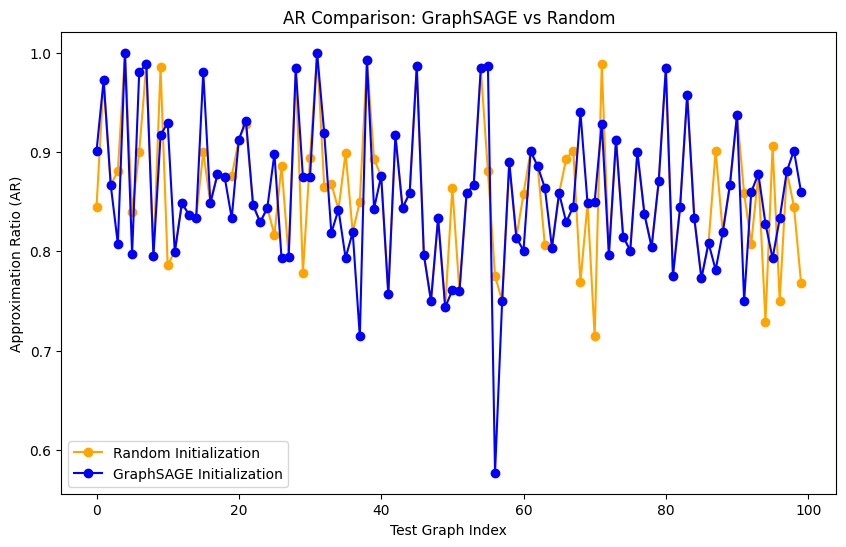

GraphSAGE - Mean AR Diff: -0.0011, Std: 0.0556


In [15]:
# 主实验
model_types = ['GCN', 'GAT', 'GIN', 'GraphSAGE']
results = {}

for model_type in model_types:
    print(f'\nTraining {model_type}...')
    model = GNNModel(model_type=model_type, input_dim=16, hidden_dim=32, output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-5
    )
    
    # 训练
    losses = train_gnn(model, train_loader, optimizer, scheduler, epochs=100, device=device)
    
    # 评估
    ar_gnn, ar_random, mean_diff, std_diff = evaluate_gnn(model, test_loader, device=device)
    results[model_type] = {'mean_diff': mean_diff, 'std_diff': std_diff}
    
    # 绘制AR对比
    plot_ar_comparison(ar_gnn, ar_random, model_type)
    
    print(f'{model_type} - Mean AR Diff: {mean_diff:.4f}, Std: {std_diff:.4f}')
    

In [16]:
# 打印表1
print('\nTable 1: Average AR Improvements')
print('| Methods | Mean Improvement |')
print('|---------|------------------|')
for model_type, res in results.items():
    print(f'| {model_type} | {res["mean_diff"]:.2f} ± {res["std_diff"]:.2f} |')


Table 1: Average AR Improvements
| Methods | Mean Improvement |
|---------|------------------|
| GCN | -0.01 ± 0.05 |
| GAT | 0.00 ± 0.06 |
| GIN | -0.00 ± 0.05 |
| GraphSAGE | -0.00 ± 0.06 |


In [17]:
print(torch.__version__)
print(torch.version.cuda)
import sys
print(sys.executable)

2.3.1
12.1
e:\Anaconda3\anaconda\envs\FOOSP\python.exe
